<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_dictionary_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cursive Transformer Mechanistic Interpretability
---
## Introduction
The purpose of this notebook is to apply the techniques of mechanistic interpretability, in particular dictionary learning, to our cursive transformer. The goal of this exercise is two-fold:
1. Attempt to gain insight into the structure and orientation of the features being learned by the model, in particular in the cross-attention and feed-forward layers
2. More generally become familiar with the latest ME techniques, as they can easily transfer to be applied beyond the scope of this project to essentially ANY transformer-based model

To this end, we will reference the following resources throughout this document:
- https://transformer-circuits.pub/2023/monosemantic-features
- https://www.alignmentforum.org/posts/fKuugaxt2XLTkASkk/open-source-replication-and-commentary-on-anthropic-s
- https://colab.research.google.com/drive/1u8larhpxy8w4mMsJiSBddNOzFGj7_RTn?usp=sharing
- https://github.com/TransformerLensOrg/TransformerLens
- https://arena3-chapter1-transformer-interp.streamlit.app/

# Setup

In [12]:
!python3 -V

Python 3.10.12


## Dependencies

In [13]:
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

# Login to Weights & Biases (replace 'your_api_key' with your actual API key)
import wandb
wandb.login()

Cloning into 'cursivetransformer'...
remote: Enumerating objects: 2384, done.
remote: Counting objects: 100% (519/519), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 2384 (delta 435), reused 449 (delta 385), pack-reused 1865 (from 1)
Receiving objects: 100% (2384/2384), 32.08 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (1349/1349), done.


wandb: Currently logged in as: zwimpee (llm-lab). Use `wandb login --relogin` to force relogin


True

## Imports

In [14]:
import sys
sys.path.append('/content/cursivetransformer')  # Adjust the path if necessary

# Import cursivetransformer modules
from cursivetransformer.model import get_all_args, get_checkpoint
from cursivetransformer.data import create_datasets, offsets_to_strokes
from cursivetransformer.sample import generate_n_words, plot_strokes

# Import other necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gradio as gr
import pprint
import json
from datasets import load_dataset
from IPython.display import HTML, display
from functools import partial
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from einops import rearrange

# Defining the Autoencoder

In [15]:
# Configuration for the autoencoder
cfg = {
    "seed": 49,
    "batch_size": 4096,
    "buffer_mult": 384,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 3e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 256,
    "d_mlp": None,  # To be set after loading the model
    "enc_dtype": "fp32",
    "remove_rare_dir": False,
}

cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to("cuda")

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

# Utils



### Get Reconstruction Loss

In [16]:
def get_recons_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []
    loss_fn = nn.CrossEntropyLoss()
    for i in range(num_batches):
        idx = torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]
        tokens = all_tokens[idx].to(model_device)
        context = all_contexts[idx].to(model_device)
        targets = all_targets[idx].to(model_device)

        # Capture MLP activations
        mlp_activations = []

        def capture_mlp_activations(module, input, output):
            mlp_activations.append(output.detach())

        # Register the hook on the MLP output layer
        mlp_layer = model.transformer.h[0].mlp.c_proj  # Adjust layer index as needed
        hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

        # Forward pass without hooks
        logits, loss = model(tokens, context, targets=targets)
        loss = loss.item()

        # Remove the hook
        hook_handle.remove()

        # Get the activations
        mlp_acts = mlp_activations[0]  # Shape: [batch_size, seq_len, d_mlp]

        # Flatten activations
        mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])

        # Reconstruct activations using encoder
        loss_enc, x_reconstruct, hidden_acts, l2_loss, l1_loss = local_encoder(mlp_acts_flattened)

        # Reconstructed activations reshaped back to original shape
        reconstructed_acts = x_reconstruct.view_as(mlp_acts)

        # Define the hook to replace activations
        def reconstruction_hook(module, input, output):
            return reconstructed_acts

        # Register the reconstruction hook
        hook_handle = mlp_layer.register_forward_hook(reconstruction_hook)
        # Forward pass with reconstructed activations
        logits_recons, loss_recons = model(tokens, context, targets=targets)
        recons_loss = loss_recons.item()
        hook_handle.remove()

        # Zero ablation
        def zero_ablation_hook(module, input, output):
            return torch.zeros_like(output)

        hook_handle = mlp_layer.register_forward_hook(zero_ablation_hook)
        logits_zero_abl, loss_zero_abl = model(tokens, context, targets=targets)
        zero_abl_loss = loss_zero_abl.item()
        hook_handle.remove()

        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(f"loss: {loss:.4f}, recons_loss: {recons_loss:.4f}, zero_abl_loss: {zero_abl_loss:.4f}")
    score = ((zero_abl_loss - recons_loss) / (zero_abl_loss - loss))
    print(f"Reconstruction Score: {score:.2%}")
    return score, loss, recons_loss, zero_abl_loss

### Get Frequencies

In [17]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        idx = torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]
        tokens = all_tokens[idx].to(model_device)
        context = all_contexts[idx].to(model_device)

        mlp_activations = []

        def capture_mlp_activations(module, input, output):
            mlp_activations.append(output.detach())

        # Register the hook on the MLP output layer
        mlp_layer = model.transformer.h[0].mlp.c_proj  # Adjust layer index as needed
        hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

        # Forward pass
        logits, _ = model(tokens, context)
        # Remove the hook
        hook_handle.remove()

        # Get the activations
        mlp_acts = mlp_activations[0]  # Shape: [batch_size, seq_len, d_mlp]
        mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])

        # Pass through encoder
        hidden = local_encoder(mlp_acts_flattened)[2]  # Get the activations

        act_freq_scores += (hidden > 0).sum(0)
        total += hidden.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead.item())
    return act_freq_scores

## Visualise Feature Utils

In [32]:
from html import escape
import colorsys
from IPython.display import display, HTML

SPACE = "·"
NEWLINE = "↩"
TAB = "→"

def create_html(strings, values, max_value=None, saturation=0.5, allow_different_length=False, return_string=False):
    # Escape strings to deal with tabs, newlines, etc.
    escaped_strings = [escape(s, quote=True) for s in strings]
    processed_strings = [
        s.replace("\n", f"{NEWLINE}<br/>").replace("\t", f"{TAB}&emsp;").replace(" ", "&nbsp;")
        for s in escaped_strings
    ]

    if isinstance(values, torch.Tensor) and len(values.shape) > 1:
        values = values.flatten().tolist()

    if not allow_different_length:
        assert len(processed_strings) == len(values)

    # Scale values
    if max_value is None:
        max_value = max(max(values), -min(values)) + 1e-3
    scaled_values = [v / max_value * saturation for v in values]

    # Create HTML
    html = ""
    for i, s in enumerate(processed_strings):
        if i < len(scaled_values):
            v = scaled_values[i]
        else:
            v = 0
        if v < 0:
            hue = 0  # Red in HSV
        else:
            hue = 0.66  # Blue in HSV
        rgb_color = colorsys.hsv_to_rgb(
            hue, v, 1
        )
        hex_color = "#%02x%02x%02x" % (
            int(rgb_color[0] * 255),
            int(rgb_color[1] * 255),
            int(rgb_color[2] * 255),
        )
        html += f'<span style="background-color: {hex_color}; border: 1px solid lightgray; font-size: 16px; border-radius: 3px;">{s}</span>'
    if return_string:
        return html
    else:
        display(HTML(html))

# - [ ] TODO: <-DEBUG THIS!!!
def stroke_to_svg(stroke_sequence):
    # This function generates an SVG path for the stroke sequence
    svg_output = ""
    pen_down = False
    for point in stroke_sequence:
        x, y, pen = point
        if pen == 1:
            if not pen_down:
                svg_output += f'M {x},{y} '
                pen_down = True
            else:
                svg_output += f'L {x},{y} '
        else:
            pen_down = False
    svg_element = f'<path d="{svg_output}" style="stroke:black;fill:none;" />'
    return svg_element

# def stroke_to_svg(stroke_sequence):
#     # This function generates an SVG path for each stroke in the sequence
#     svg_output = ""
#     for stroke in stroke_sequence:
#         if stroke[2] == 0:
#           continue
#         svg_output += f'<path d="M{stroke[0]},{stroke[1]}'
#         # for point in stroke[1:]:
#         #     svg_output += f' L{point[0]},{point[1]}'
#     svg_output += '" style="stroke:black;fill:none;" />'
#     return svg_output

def basic_feature_vis(text, feature_index, max_val=0):
    feature_in = encoder.W_enc[:, feature_index]
    feature_bias = encoder.b_enc[feature_index]

    # Encode the context text
    c = test_dataset.encode_text(text).unsqueeze(0).to(model_device)  # Context tokens

    # Initialize tokens with a START token or zeros
    # Assuming START_TOKEN is defined in your dataset
    START_TOKEN = test_dataset.END_TOKEN  # Using END_TOKEN as a placeholder
    x = torch.full((1, 1), START_TOKEN, dtype=torch.long).to(model_device)  # Initial token

    # Generate stroke tokens conditioned on the context text
    max_new_tokens = args.max_seq_length - 1  # Adjust based on your sequence length
    tokens = generate(model, x, c, max_new_tokens, temperature=1.0, do_sample=False).to(model_device)

    # Capture MLP activations
    mlp_activations = []

    def capture_mlp_activations(module, input, output):
        mlp_activations.append(output.detach())

    # Register the hook
    mlp_layer = model.transformer.h[0].mlp.c_proj
    hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

    # Forward pass with the generated tokens and context
    logits, _ = model(tokens, c)
    hook_handle.remove()

    # Get the activations
    mlp_acts = mlp_activations[0][0].cpu()  # Shape: [seq_len, d_mlp]
    feature_acts = F.relu((mlp_acts - encoder.b_dec.cpu()) @ feature_in.cpu() + feature_bias.cpu())

    if max_val == 0:
        max_val = max(1e-7, feature_acts.max().item())

    # Decode stroke tokens back to the original stroke format
    stroke_sequence = [offsets_to_strokes(test_dataset.decode_stroke(t)) for t in tokens]

    # Convert decoded strokes to SVG format for visualization
    stroke_svgs = [stroke_to_svg(stroke) for stroke in stroke_sequence]

    # Flatten the lists if necessary
    stroke_svgs = [item for sublist in stroke_svgs for item in sublist]
    feature_acts = feature_acts.flatten()

    # Ensure the lengths match
    min_length = min(len(stroke_svgs), len(feature_acts))
    stroke_svgs = stroke_svgs[:min_length]
    feature_acts = feature_acts[:min_length]

    return basic_token_vis_make_str(stroke_svgs, feature_acts, max_val)

# def basic_feature_vis(feature_index, max_val=0):
#     feature_in = encoder.W_enc[:, feature_index]
#     feature_bias = encoder.b_enc[feature_index]

#     # Get a sample stroke sequence and context from the dataset
#     x, c, _ = test_dataset[0]  # You can choose any index or randomize
#     tokens = x.unsqueeze(0).to(model_device)  # Stroke tokens
#     context = c.unsqueeze(0).to(model_device)  # Context tokens

#     # Capture MLP activations
#     mlp_activations = []

#     def capture_mlp_activations(module, input, output):
#         mlp_activations.append(output.detach())

#     # Register the hook
#     mlp_layer = model.transformer.h[0].mlp.c_proj
#     hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

#     # Forward pass
#     logits, _ = model(tokens, context)
#     hook_handle.remove()

#     # Get the activations
#     mlp_acts = mlp_activations[0][0].cpu()  # Shape: [seq_len, d_mlp]
#     feature_acts = F.relu((mlp_acts - encoder.b_dec.cpu()) @ feature_in.cpu() + feature_bias.cpu())
#     if max_val == 0:
#         max_val = max(1e-7, feature_acts.max().item())

#     # Decode stroke tokens back to the original stroke format
#     stroke_sequence = [offsets_to_strokes(test_dataset.decode_stroke(t)) for t in tokens]

#     # Convert decoded strokes to SVG format for visualization
#     stroke_svgs = [stroke_to_svg(stroke) for stroke in stroke_sequence]

#     return basic_token_vis_make_str(stroke_svgs, feature_acts, max_val)


def basic_token_vis_make_str(strings, values, max_val=None):
    if not isinstance(strings, list):
        strings = list(strings)
    values = values.detach().numpy()
    if max_val is None:
        max_val = values.max()
    header_string = f"<h4>Max Range <b>{values.max():.4f}</b> Min Range: <b>{values.min():.4f}</b></h4>"
    header_string += f"<h4>Set Max Range <b>{max_val:.4f}</b></h4>"
    body_string = create_html(strings, values, max_value=max_val, return_string=True, allow_different_length=True)
    return header_string + body_string

### Make Token DataFrame

In [19]:
def make_token_df(tokens, len_prefix=5, len_suffix=1):
    str_tokens = [str(t.item()) for t in tokens]
    unique_token = [f"{s}/{i}" for i, s in enumerate(str_tokens)]

    context = []
    batch = []
    pos = []
    label = []
    for p in range(len(tokens)):
        prefix = "".join(str_tokens[max(0, p - len_prefix):p])
        if p == len(tokens) - 1:
            suffix = ""
        else:
            suffix = "".join(str_tokens[p + 1:min(len(tokens) - 1, p + 1 + len_suffix)])
        current = str_tokens[p]
        context.append(f"{prefix}|{current}|{suffix}")
        batch.append(0)  # Since we have a single batch
        pos.append(p)
        label.append(f"{0}/{p}")
    return pd.DataFrame(dict(
        str_tokens=str_tokens,
        unique_token=unique_token,
        context=context,
        batch=batch,
        pos=pos,
        label=label,
    ))

## Loading the Model

In [20]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

model, optimizer, scheduler, step, best_loss = get_checkpoint(args)


cfg["d_mlp"] = args.n_embd  # Assuming n_embd is the MLP dimension
args

For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples
Number of Transformer parameters: 368064
Model #params: 397184
Loaded model from local path: best_checkpoint.pt


namespace(max_steps=110000,
          print_every=100,
          log_every=2500,
          lr_decay=0.333,
          step_lr_every=33000,
          device='cuda',
          seed=42,
          n_layer=4,
          n_embd=64,
          n_embd2=64,
          n_ctx_head=4,
          learning_rate=0.01,
          weight_decay=0.0001,
          batch_size=32,
          train_size=497000,
          test_size=3000,
          num_words=4,
          max_seq_length=1000,
          augment=True,
          ablate_cross_attention=False,
          downsample_mean=0.65,
          downsample_width=0.1,
          add_digits=True,
          alphabet=' enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"\'(BCQLMWYU,ZF!DXV?KPGJ',
          dataset_name='bigbank',
          wandb_project='bigbank_experiments',
          wandb_entity='sam-greydanus',
          wandb_run_name='cursivetransformer_dictionary_learning',
          wandb_api_key=None,
          load_from_run_id='6le6tujz',
          sample_only=True,


In [21]:
model_device = 'cuda'
model = model.to(model_device)
model = model.eval()  # Set model to evaluation mode

## Generate N words

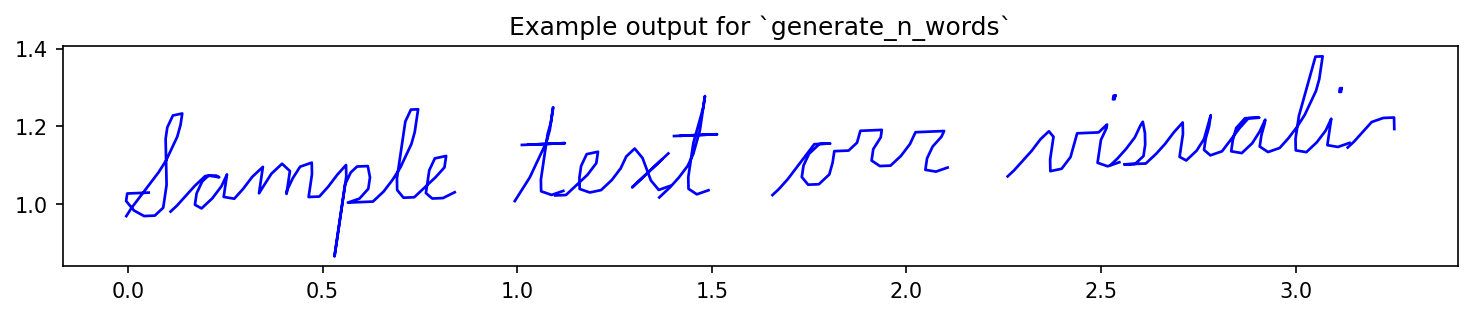

In [22]:
point_samp = generate_n_words(model, test_dataset, "Sample text for visualization", model_device='cuda', n_words = 4)
_ = plot_strokes(point_samp, "Example output for `generate_n_words`")

# Loading Data

In [23]:
batch_size = cfg["model_batch_size"] # - [ ] TODO: Determine if this is needed?
num_samples = len(test_dataset)
stroke_seqs = []
contexts = []
targets = []

for i in range(num_samples):
    x, c, y = test_dataset[i]
    stroke_seqs.append(x)
    contexts.append(c)
    targets.append(y)

all_tokens = torch.stack(stroke_seqs)
all_contexts = torch.stack(contexts)
all_targets = torch.stack(targets)

# Analysis



## Initialize the Autoencoder

In [24]:
encoder = AutoEncoder(cfg)

# Train the Autoencoder

In [25]:
def train_sae(model, encoder, num_batches=5000, batch_size=256):
    optimizer = torch.optim.Adam(encoder.parameters(), lr=cfg['lr'], betas=(cfg['beta1'], cfg['beta2']))

    for batch in tqdm.tqdm(range(num_batches)):
        optimizer.zero_grad()

        # Sample data
        idx = torch.randperm(len(all_tokens))[:batch_size]
        tokens = all_tokens[idx].to(model_device)
        contexts = all_contexts[idx].to(model_device)

        # Capture MLP activations
        mlp_activations = []
        def capture_mlp_activations(module, input, output):
            mlp_activations.append(output.detach())

        # Register the hook
        mlp_layer = model.transformer.h[0].mlp.c_proj
        hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

        # Forward pass
        with torch.no_grad():
            _ = model(tokens, contexts)

        # Remove the hook
        hook_handle.remove()

        # Get the activations
        mlp_acts = mlp_activations[0].reshape(-1, cfg["d_mlp"])

        # Pass through encoder
        loss, _, _, l2_loss, l1_loss = encoder(mlp_acts)

        # Backward pass
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(f"Batch {batch}, Loss: {loss.item():.4f}, L2 Loss: {l2_loss.item():.4f}, L1 Loss: {l1_loss.item():.4f}")

    print("SAE training completed.")

# Train the SAE
train_sae(model, encoder)
# Save the encoder weights
# torch.save(encoder.state_dict(), 'encoder_weights.pth')

  0%|          | 0/5000 [00:00<?, ?it/s]

Batch 0, Loss: 241332.0938, L2 Loss: 75172.5859, L1 Loss: 166159.5000
Batch 10, Loss: 214066.2812, L2 Loss: 56957.3203, L1 Loss: 157108.9688
Batch 20, Loss: 199604.7500, L2 Loss: 46454.2109, L1 Loss: 153150.5469
Batch 30, Loss: 181658.2812, L2 Loss: 37208.3477, L1 Loss: 144449.9375
Batch 40, Loss: 155653.8594, L2 Loss: 28417.0527, L1 Loss: 127236.8125
Batch 50, Loss: 148265.1719, L2 Loss: 25845.4805, L1 Loss: 122419.6953
Batch 60, Loss: 139325.7031, L2 Loss: 23541.7852, L1 Loss: 115783.9219
Batch 70, Loss: 129620.6562, L2 Loss: 21665.4883, L1 Loss: 107955.1719
Batch 80, Loss: 122666.4688, L2 Loss: 20573.6719, L1 Loss: 102092.7969
Batch 90, Loss: 114763.4141, L2 Loss: 19429.5312, L1 Loss: 95333.8828
Batch 100, Loss: 105333.3516, L2 Loss: 18193.7402, L1 Loss: 87139.6094
Batch 110, Loss: 101712.8750, L2 Loss: 18118.3906, L1 Loss: 83594.4844
Batch 120, Loss: 94465.1953, L2 Loss: 17316.6172, L1 Loss: 77148.5781
Batch 130, Loss: 89969.6406, L2 Loss: 17097.2930, L1 Loss: 72872.3516
Batch 140,

## Using the Autoencoder

In [26]:
_ = get_recons_loss(num_batches=5, local_encoder=encoder) # - [ ] TODO: Increase number of batches?

loss: 1.1043, recons_loss: 2.9206, zero_abl_loss: 14.7330
Reconstruction Score: 86.67%


## Get Frequencies

  0%|          | 0/25 [00:00<?, ?it/s]

Num dead 0.87890625


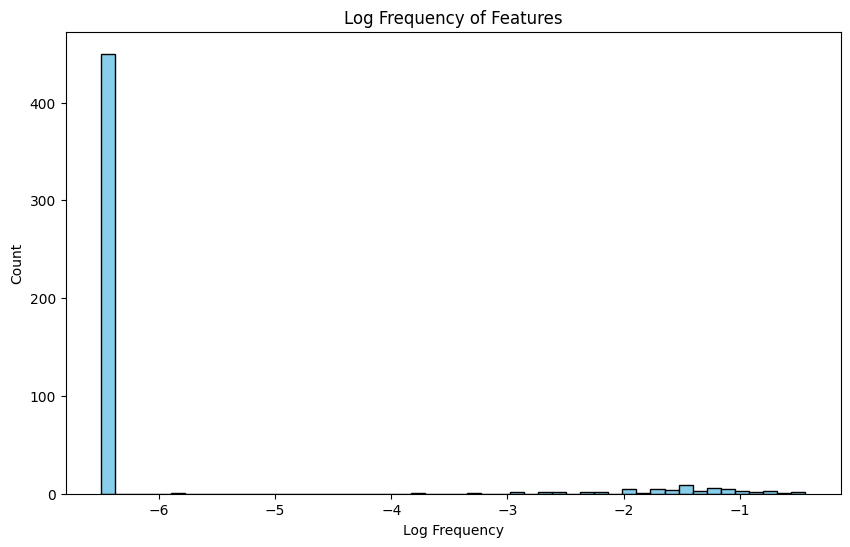

In [27]:
freqs = get_freqs(num_batches=25, local_encoder=encoder)

# Add 1e-6.5 so that dead features show up as log_freq -6.5
log_freq = (freqs + 10 ** -6.5).log10().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.hist(log_freq, bins=50, color='skyblue', edgecolor='black')
plt.title("Log Frequency of Features")
plt.xlabel("Log Frequency")
plt.ylabel("Count")
plt.show()

## Interpreting A Feature

Let's investigate the features

In [28]:
# - [ ] TODO: Enhance and extend this logic to be more modular
import pandas as pd

feature_id = 18 # Change as needed
batch_size = 128  # Adjust as needed

print(f"Feature freq: {freqs[feature_id].item():.4f}")

# Get activations
idx = torch.randperm(len(all_tokens))[:batch_size]
tokens = all_tokens[idx].to(model_device)
contexts = all_contexts[idx].to(model_device)
targets = all_targets[idx].to(model_device)

mlp_activations = []

def capture_mlp_activations(module, input, output):
    mlp_activations.append(output.detach())

# Register the hook
mlp_layer = model.transformer.h[0].mlp.c_proj
hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

# Forward pass
logits, _ = model(tokens, contexts)
# Remove the hook
hook_handle.remove()

# Get the activations
mlp_acts = mlp_activations[0]  # Shape: [batch_size, seq_len, d_mlp]
mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])

# Pass through encoder
loss_enc, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(mlp_acts_flattened)
print("hidden_acts.shape", hidden_acts.shape)

# Create token dataframe
token_df = make_token_df(tokens.cpu().flatten())
token_df["feature"] = hidden_acts[:, feature_id].detach().cpu().numpy()
display(token_df.sort_values("feature", ascending=False).head(20))

Feature freq: 0.0337
hidden_acts.shape torch.Size([128000, 512])


,str_tokens,unique_token,context,batch,pos,label,feature
126028,439,439/126028,1513527645119|439|21,0,126028,0/126028,29.820944
48826,439,439/48826,143371137610|439|21,0,48826,0/48826,28.412743
97920,439,439/97920,244042842529|439|32,0,97920,0/97920,28.192667
82064,433,433/82064,383701945129|433|30,0,82064,0/82064,27.944721
46040,433,433/46040,933151945129|433|43,0,46040,0/46040,27.735754
44888,439,439/44888,304163042221|439|30,0,44888,0/44888,27.547327
44958,434,434/44958,313453134120|434|22,0,44958,0/44958,27.329151
42628,439,439/42628,213383031915|439|30,0,42628,0/42628,27.304499
67016,434,434/67016,243451045129|434|51,0,67016,0/67016,27.290855
76032,434,434/76032,304013141631|434|31,0,76032,0/76032,27.273802


In [29]:
interesting_feature_ids = [2, 5, 18]

In [30]:
len(freqs)

512

## TODO: DEBUG: Visualizing Feature Activations

In [34]:
# Access the character-to-index and index-to-character mappings from the dataset
char2idx = train_dataset.stoi  # Character to index mapping
idx2char = train_dataset.itos  # Index to character mapping

# Define the tokenization function using the dataset's mapping
def tokenize_text(text):
    # Map each character to its index, default to PAD token (0) for unknown characters
    return [char2idx.get(ch, train_dataset.char_PAD_TOKEN) for ch in text]

def make_feature_vis_gradio(feature_id, starting_text=None):
    if starting_text is None:
        starting_text = "Sample text for visualization"

    with gr.Blocks() as demo:
        gr.HTML(value=f"<h3>Interactive Feature Visualization for cursivetransformer</h3>")
        # The input elements
        with gr.Row():
            with gr.Column():
                text = gr.Textbox(label="Context Text", value=starting_text)
                feature_index = gr.Number(
                    label="Feature Index", value=feature_id, precision=0
                )
                max_val = gr.Number(label="Max Value", value=0)
                inputs = [text, feature_index, max_val]
        with gr.Row():
            with gr.Column():
                # The output element
                out = gr.HTML(label="Neuron Activations", value="")
        def update_output(text_input, feature_idx, max_value):
            return basic_feature_vis(text_input, int(feature_idx), max_value)
        for inp in inputs:
            inp.change(update_output, inputs, out)
    demo.launch(share=True)


# def make_feature_vis_gradio(feature_id, starting_text=None):
#     if starting_text is None:
#         starting_text = "Sample text for visualization"

#     with gr.Blocks() as demo:
#         gr.HTML(value=f"Hacky Interactive Neuroscope for cursivetransformer")
#         # The input elements
#         with gr.Row():
#             with gr.Column():
#                 text = gr.Textbox(label="Context Text", value=starting_text)
#                 feature_index = gr.Number(
#                     label="Feature Index", value=feature_id, precision=0
#                 )
#                 max_val = gr.Number(label="Max Value", value=None)
#                 inputs = [text, feature_index, max_val]
#         with gr.Row():
#             with gr.Column():
#                 # The output element
#                 out = gr.HTML(label="Neuron Acts", value=basic_feature_vis(feature_id))
#         def update_output(text, feature_index, max_val):
#             return basic_feature_vis(text, int(feature_index), max_val)
#         for inp in inputs:
#             inp.change(update_output, inputs, out)
#     demo.launch(share=True)

# # Visualize the feature activations
starting_text = "Sample text to test feature activations in cursivetransformer"
make_feature_vis_gradio(feature_id, starting_text)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5118b30898a260a4c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
